In [73]:
# TensorFlow and tf.keras
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
import glob
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

import cv2 as cv
import argparse
import easydict
import time

In [74]:
allpersons = ["hakkani","mosarrof","tomo","maruf","nobo","arjun","nogami","arif","saidur"]

In [75]:
print(allpersons.index("saidur"))

8


In [76]:
imagep = glob.glob("./images/*.jpg");
darray = [[0,""]];
#print(imagep)
for i in imagep:
    for j in allpersons:
        if i.find(j) != -1:
            #print(j+":"+i+"\n")
            darray = np.append(darray,[[j,i]], axis=0)

darray = np.delete(darray, 0, 0)
print(darray)

[['hakkani' './images/hakkani4.jpg']
 ['mosarrof' './images/mosarrof15.jpg']
 ['tomo' './images/tomo11.jpg']
 ['maruf' './images/maruf2.jpg']
 ['nobo' './images/nobo4.jpg']
 ['tomo' './images/tomo10.jpg']
 ['arjun' './images/arjun18.jpg']
 ['tomo' './images/tomo22.jpg']
 ['tomo' './images/tomo24.jpg']
 ['maruf' './images/maruf4.jpg']
 ['mosarrof' './images/mosarrof9.jpg']
 ['nogami' './images/nogami1.jpg']
 ['hakkani' './images/hakkani9.jpg']
 ['hakkani' './images/hakkani16.jpg']
 ['saidur' './images/saidur15.jpg']
 ['nobo' './images/nobo20.jpg']
 ['hakkani' './images/hakkani15.jpg']
 ['mosarrof' './images/mosarrof23.jpg']
 ['hakkani' './images/hakkani2.jpg']
 ['arjun' './images/arjun10.jpg']
 ['nobo' './images/nobo2.jpg']
 ['arjun' './images/arjun2.jpg']
 ['maruf' './images/maruf15.jpg']
 ['nobo' './images/nobo15.jpg']
 ['arjun' './images/arjun5.jpg']
 ['hakkani' './images/hakkani13.jpg']
 ['saidur' './images/saidur17.jpg']
 ['arif' './images/arif2.jpg']
 ['saidur' './images/saidur4.j

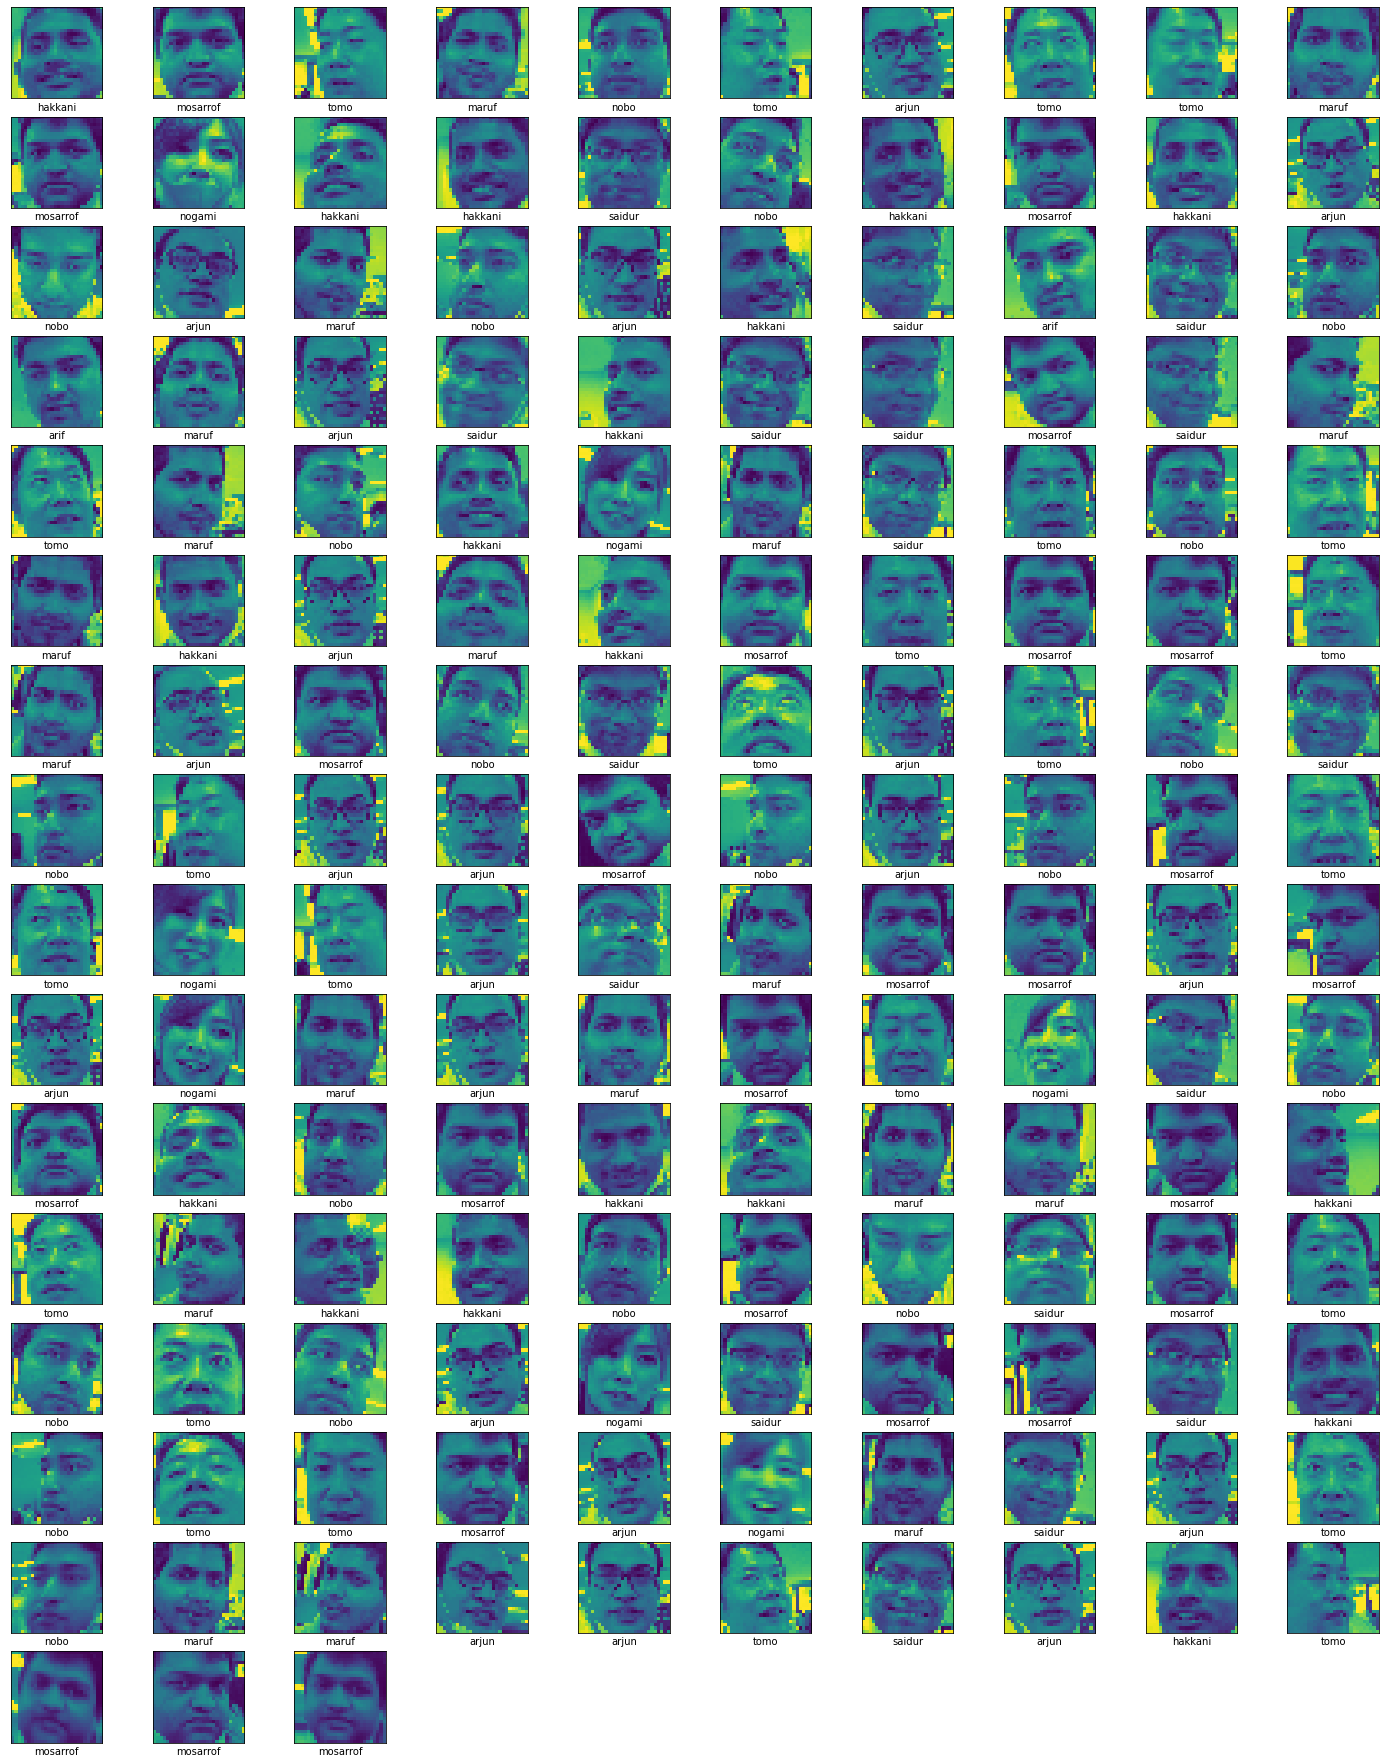

In [77]:
plt.figure(figsize=(25,40))
i=0
collected_image_data = []
train_lebel = []
for f in darray:
    #print(f[1])
    img = load_img(f[1], grayscale=False, color_mode='rgb', target_size=(28,28))
    # convert to numpy array
    img_array = img_to_array(img)

    img_array1 = img_array[:,:,1]
    img_array1 = img_array1/255
    collected_image_data.append(img_array1)
    plt.subplot(20,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_array1)
    plt.xlabel(f[0])
    train_lebel.append(allpersons.index(f[0]))
    i+=1
    
train_images = np.array(collected_image_data)
train_lebels = np.array(train_lebel)
plt.show()

In [78]:
#print(train_images[0])
print(train_lebel)

[0, 1, 2, 3, 4, 2, 5, 2, 2, 3, 1, 6, 0, 0, 8, 4, 0, 1, 0, 5, 4, 5, 3, 4, 5, 0, 8, 7, 8, 4, 7, 3, 5, 8, 0, 8, 8, 1, 8, 3, 2, 3, 4, 0, 6, 3, 8, 2, 4, 2, 3, 0, 5, 3, 0, 1, 2, 1, 1, 2, 3, 5, 1, 4, 8, 2, 5, 2, 4, 8, 4, 2, 5, 5, 1, 4, 5, 4, 1, 2, 2, 6, 2, 5, 8, 3, 1, 1, 5, 1, 5, 6, 3, 5, 3, 1, 2, 6, 8, 4, 1, 0, 4, 1, 0, 0, 3, 3, 1, 0, 2, 3, 0, 0, 4, 1, 4, 8, 1, 2, 4, 2, 4, 5, 6, 8, 1, 1, 8, 0, 4, 2, 2, 1, 5, 6, 3, 8, 5, 2, 4, 3, 3, 5, 5, 2, 8, 5, 0, 2, 1, 1, 1]


In [79]:
print(train_images.shape)
print(train_lebel)

(153, 28, 28)
[0, 1, 2, 3, 4, 2, 5, 2, 2, 3, 1, 6, 0, 0, 8, 4, 0, 1, 0, 5, 4, 5, 3, 4, 5, 0, 8, 7, 8, 4, 7, 3, 5, 8, 0, 8, 8, 1, 8, 3, 2, 3, 4, 0, 6, 3, 8, 2, 4, 2, 3, 0, 5, 3, 0, 1, 2, 1, 1, 2, 3, 5, 1, 4, 8, 2, 5, 2, 4, 8, 4, 2, 5, 5, 1, 4, 5, 4, 1, 2, 2, 6, 2, 5, 8, 3, 1, 1, 5, 1, 5, 6, 3, 5, 3, 1, 2, 6, 8, 4, 1, 0, 4, 1, 0, 0, 3, 3, 1, 0, 2, 3, 0, 0, 4, 1, 4, 8, 1, 2, 4, 2, 4, 5, 6, 8, 1, 1, 8, 0, 4, 2, 2, 1, 5, 6, 3, 8, 5, 2, 4, 3, 3, 5, 5, 2, 8, 5, 0, 2, 1, 1, 1]


In [80]:
#Sequential model preparing
digit_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

In [81]:
#compiling the model
digit_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [82]:
#training the model with train data
digit_model.fit(train_images, train_lebels, epochs=10)

Epoch 1/10
5/5 [==============================] - 0s 811us/step - loss: 2.2127 - accuracy: 0.1830
Epoch 2/10
5/5 [==============================] - 0s 891us/step - loss: 1.8460 - accuracy: 0.4379
Epoch 3/10
5/5 [==============================] - 0s 1ms/step - loss: 1.6488 - accuracy: 0.5817
Epoch 4/10
5/5 [==============================] - 0s 936us/step - loss: 1.4559 - accuracy: 0.6471
Epoch 5/10
5/5 [==============================] - 0s 1ms/step - loss: 1.2918 - accuracy: 0.7255
Epoch 6/10
5/5 [==============================] - 0s 816us/step - loss: 1.1517 - accuracy: 0.7320
Epoch 7/10
5/5 [==============================] - 0s 1ms/step - loss: 1.0156 - accuracy: 0.8693
Epoch 8/10
5/5 [==============================] - 0s 1ms/step - loss: 0.9240 - accuracy: 0.9020
Epoch 9/10
5/5 [==============================] - 0s 1ms/step - loss: 0.8245 - accuracy: 0.8824
Epoch 10/10
5/5 [==============================] - 0s 910us/step - loss: 0.7496 - accuracy: 0.9281


In [83]:
#probability model prepare from trained digit model 
probability_model = tf.keras.Sequential([digit_model, 
                                         tf.keras.layers.Softmax()])

In [85]:
def detectAndDisplay(frame):
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)

    #-- Detect faces
    faces = face_cascade.detectMultiScale(frame_gray)
    count = 0
    for (x,y,w,h) in faces:
        crop_img = frame[y:y+h, x:x+w]
        #cv.imwrite("frame%d.jpg" % round(time.time()), crop_img)     # save frame as JPEG file 
        #predictions = probability_model.predict(test_data)
        crop_img1 = cv.resize(crop_img, (28, 28))
        img_array1 = crop_img1[:,:,1]
        img_array1 = img_array1/255
        
        img1 = (np.expand_dims(img_array1,0))
        predictions_single = probability_model.predict(img1)
        
        print(allpersons[np.argmax(predictions_single[0])])
        
        print(img_array1.shape)
        plt.figure(figsize=(5,5))
        plt.imshow(img_array1)
        plt.colorbar()
        plt.grid(False)
        plt.show()
        
        print(crop_img1.shape)
        count += 1
        center = (x + w//2, y + h//2)
        frame = cv.ellipse(frame, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        frame = cv.rectangle(frame, (x,y), (x+w,y+h), (255, 255, 0), 4)
        
        

        faceROI = frame_gray[y:y+h,x:x+w]
        #-- In each face, detect eyes
        eyes = eyes_cascade.detectMultiScale(faceROI)
        for (x2,y2,w2,h2) in eyes:
            eye_center = (x + x2 + w2//2, y + y2 + h2//2)
            radius = int(round((w2 + h2)*0.25))
            frame = cv.circle(frame, eye_center, radius, (255, 0, 0 ), 4)

    cv.imshow('Capture - Face detection', frame)

In [88]:
args = easydict.EasyDict({
        "face_cascade": 'data/haarcascade_frontalface_alt.xml',
        "eyes_cascade": 'data/haarcascade_eye_tree_eyeglasses.xml',
        "camera": 0
})
face_cascade_name = args.face_cascade
eyes_cascade_name = args.eyes_cascade
face_cascade = cv.CascadeClassifier()
eyes_cascade = cv.CascadeClassifier()

#-- 1. Load the cascades
if not face_cascade.load('/home/ai-lab1/.local/lib/python3.6/site-packages/cv2/'+face_cascade_name):
    print('--(!)Error loading face cascade')
    exit(0)
if not eyes_cascade.load('/home/ai-lab1/.local/lib/python3.6/site-packages/cv2/'+eyes_cascade_name):
    print('--(!)Error loading eyes cascade')
    exit(0)
    
camera_device = args.camera
#-- 2. Read the video stream
cap = cv.VideoCapture(camera_device)

if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)
    

mosarrof
(28, 28)


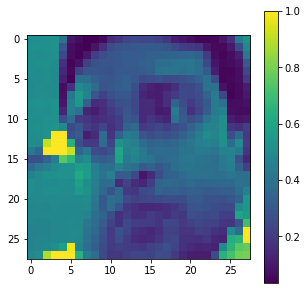

(28, 28, 3)
nobo
(28, 28)


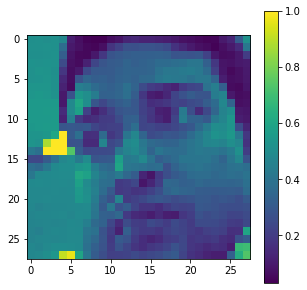

(28, 28, 3)
nobo
(28, 28)


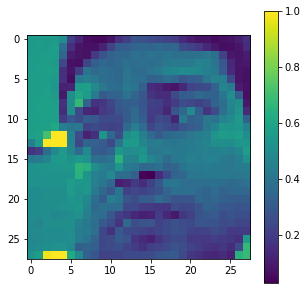

(28, 28, 3)
nobo
(28, 28)


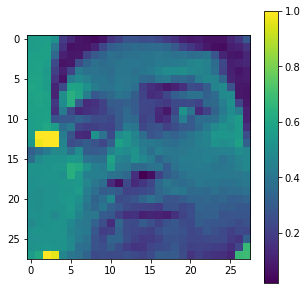

(28, 28, 3)
nobo
(28, 28)


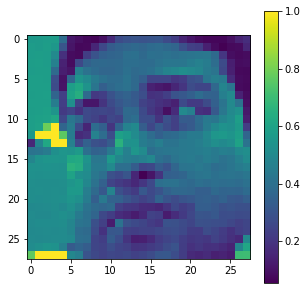

(28, 28, 3)
nobo
(28, 28)


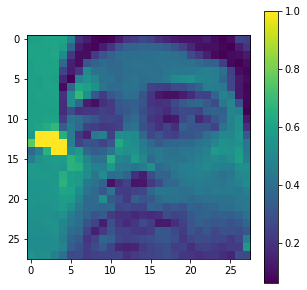

(28, 28, 3)
nobo
(28, 28)


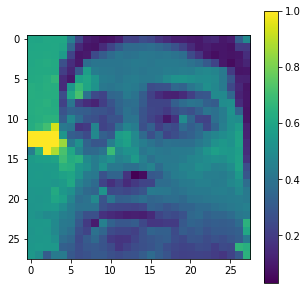

(28, 28, 3)
nobo
(28, 28)


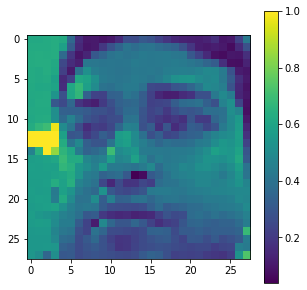

(28, 28, 3)
nobo
(28, 28)


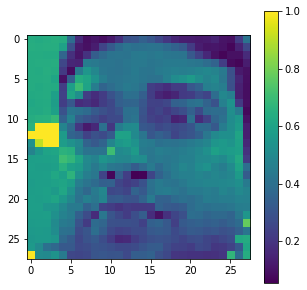

(28, 28, 3)
nobo
(28, 28)


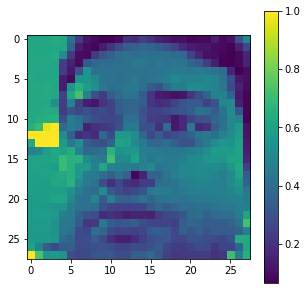

(28, 28, 3)
nobo
(28, 28)


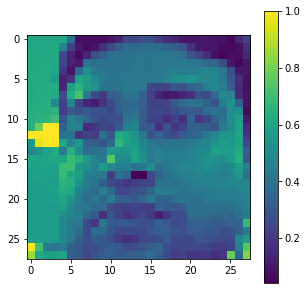

(28, 28, 3)
nobo
(28, 28)


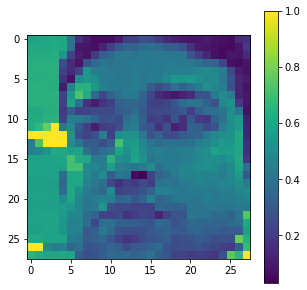

(28, 28, 3)
nobo
(28, 28)


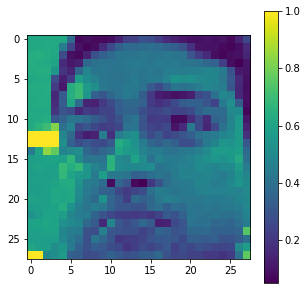

(28, 28, 3)
nobo
(28, 28)


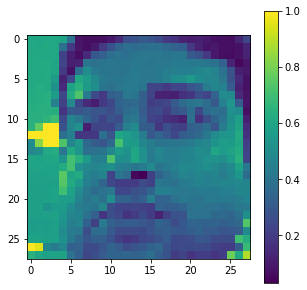

(28, 28, 3)
nobo
(28, 28)


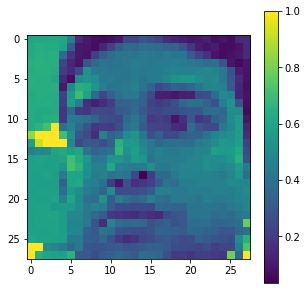

(28, 28, 3)
nobo
(28, 28)


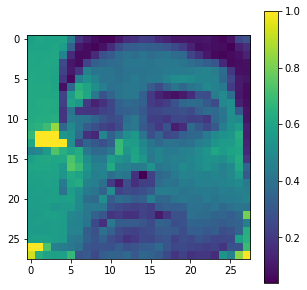

(28, 28, 3)
nobo
(28, 28)


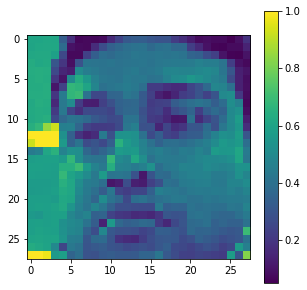

(28, 28, 3)
nobo
(28, 28)


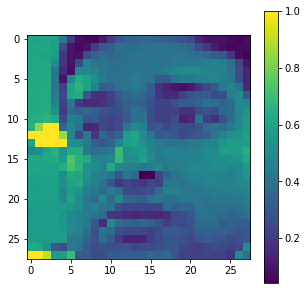

(28, 28, 3)
nobo
(28, 28)


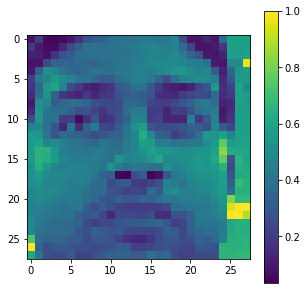

(28, 28, 3)
nobo
(28, 28)


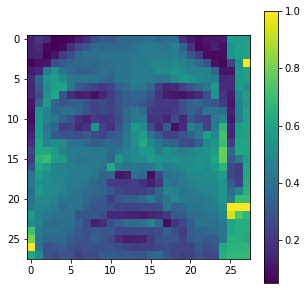

(28, 28, 3)
nobo
(28, 28)


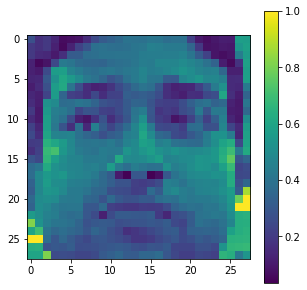

(28, 28, 3)
nobo
(28, 28)


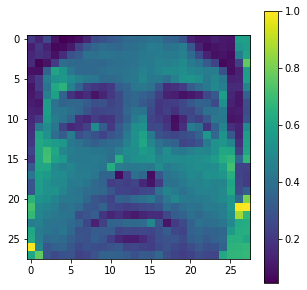

(28, 28, 3)
nobo
(28, 28)


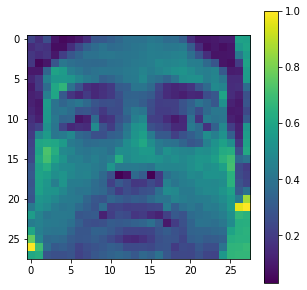

(28, 28, 3)
tomo
(28, 28)


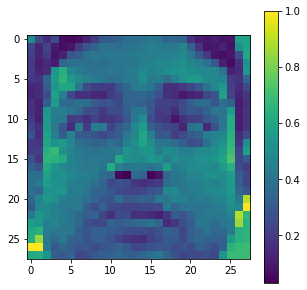

(28, 28, 3)
tomo
(28, 28)


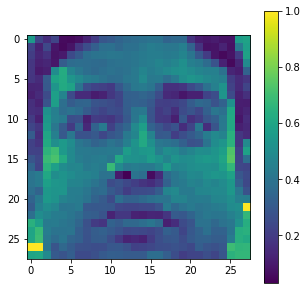

(28, 28, 3)
tomo
(28, 28)


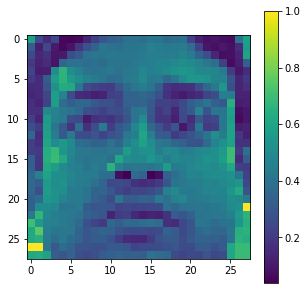

(28, 28, 3)
tomo
(28, 28)


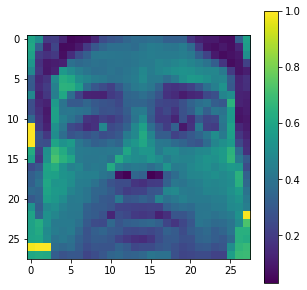

(28, 28, 3)
nobo
(28, 28)


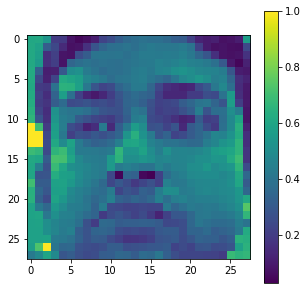

(28, 28, 3)
nobo
(28, 28)


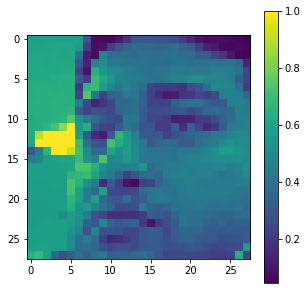

(28, 28, 3)
nobo
(28, 28)


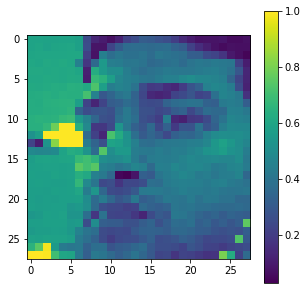

(28, 28, 3)
nobo
(28, 28)


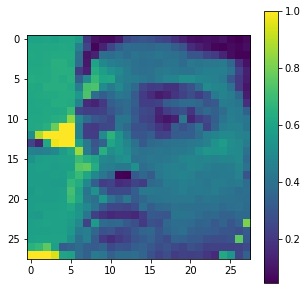

(28, 28, 3)
nobo
(28, 28)


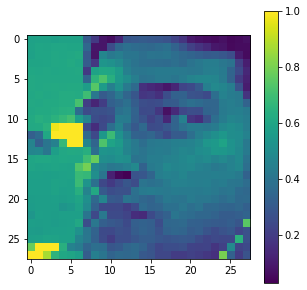

(28, 28, 3)
nobo
(28, 28)


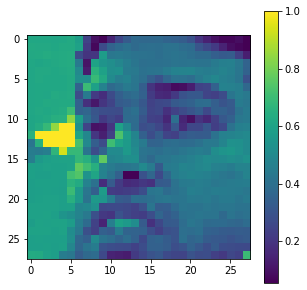

(28, 28, 3)
nobo
(28, 28)


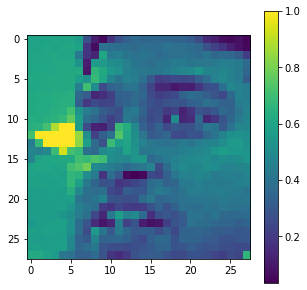

(28, 28, 3)
nobo
(28, 28)


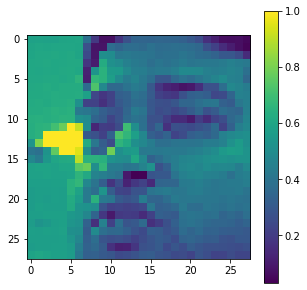

(28, 28, 3)
nobo
(28, 28)


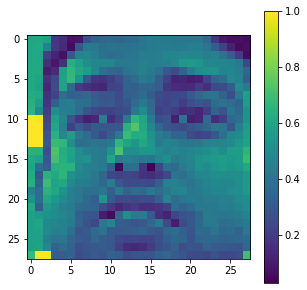

(28, 28, 3)
nobo
(28, 28)


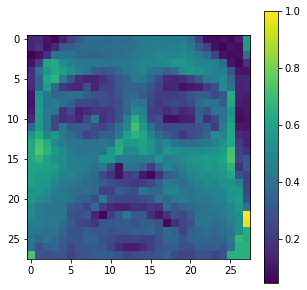

(28, 28, 3)
nobo
(28, 28)


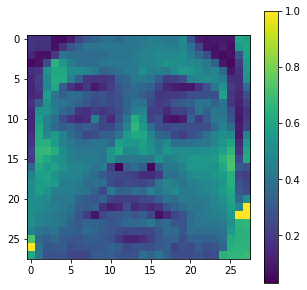

(28, 28, 3)
nobo
(28, 28)


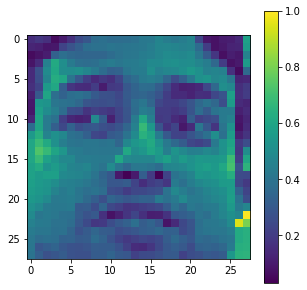

(28, 28, 3)
nobo
(28, 28)


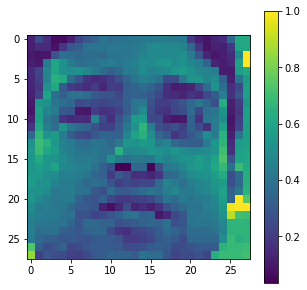

(28, 28, 3)
nobo
(28, 28)


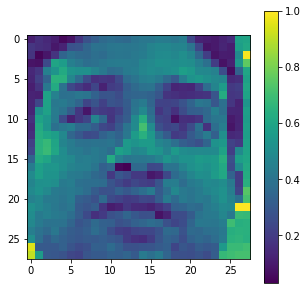

(28, 28, 3)
nobo
(28, 28)


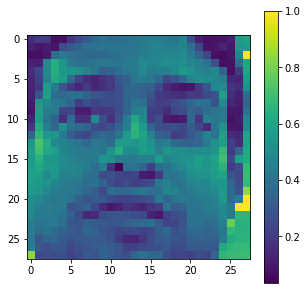

(28, 28, 3)
nobo
(28, 28)


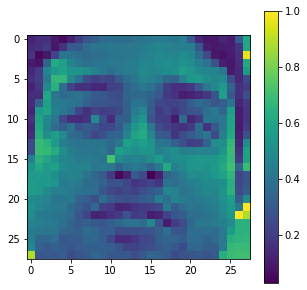

(28, 28, 3)
nobo
(28, 28)


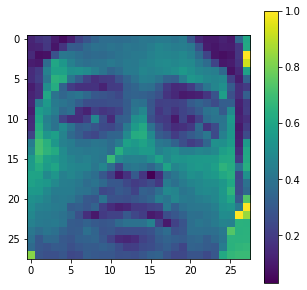

(28, 28, 3)
nobo
(28, 28)


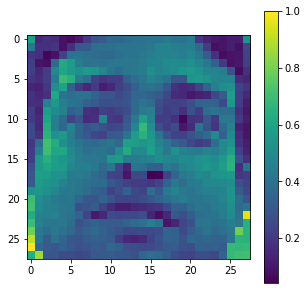

(28, 28, 3)
nobo
(28, 28)


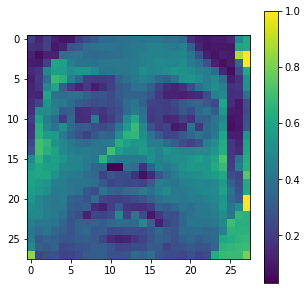

(28, 28, 3)
nobo
(28, 28)


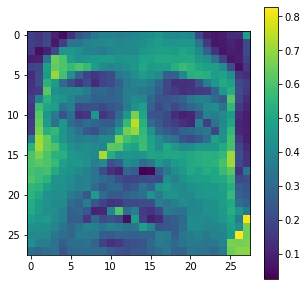

(28, 28, 3)


In [89]:
while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        break

    detectAndDisplay(frame)   
    if cv.waitKey(10) == 27:
        break